# Sentiment Analysis of Caltrain Tweets

To detect the sentiment of incoming tweets about Caltrain, we need a model that can recognize positive and negative sentiment in documents (tweets, in our case). To train this model, we first need a dataset of tweets that have been pre-assigned a sentiment. Here we use the Sentiment140 dataset, found here: http://help.sentiment140.com/for-students/. This dataset consists of 1.6m tweets, each labeled with the corresponding sentiment (0 for negative and 4 for positive). In the Sentiment140 dataset, sentiment was automatically assigned by looking at the use of emoticons in the tweet text: those tweets containing negative emoticons are assigned a negative sentiment, and those with positive emoticons are assigned a postive sentiment. 

In [16]:
import pandas as pd

# read in the Sentiment140 dataset
sentiment140 = pd.read_csv('training.1600000.processed.noemoticon.csv', header=None, encoding="ISO-8859-1")
sentiment140.columns = ['polarity', 'tweet_id', 'date', 'query', 'user', 'text']

# re-format the sentiment to allow for binary classification
sentiment140['sentiment'] = sentiment140['polarity'].apply(lambda pol: 0 if pol == 0 else 1)

# show the first few lines
sentiment140.head()

,polarity,tweet_id,date,query,user,text,sentiment
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,0
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,0
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,0
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",0


The dataset contains 6 fields:

**`polarity`** = the assigned sentiment of the tweet (0 - negative, 4 - positive)

**`tweet-id`** = unique id for the tweet

**`date`** = the timestamp for the tweet

**`user`** = twitter handle who sent the tweet

**`text`** = the text of the tweet

In [17]:
# determine the proportion of positive and negative tweets in the dataset
negative_tweets = sentiment140[sentiment140['sentiment'] == 0]
positive_tweets = sentiment140[sentiment140['sentiment'] == 1]
print(("There are {} positive and {} negative tweets in the dataset.").format(positive_tweets.shape[0], 
                                                                              negative_tweets.shape[0]))

There are 800000 positive and 800000 negative tweets in the dataset.


This dataset contains an even number of positive and negative tweets.

### Train-Test-Split

Before any models are trained, it is best to split the available data into training and test sets. **`scikit-learn`** includes a method for automatically splitting the data into randomly shuffled training and test sets. In the code below, we hold out 20% of the data as a test set.  

In [18]:
# split the data into training and test sets
from sklearn.cross_validation import train_test_split
tweets_train, tweets_test, labels_train, labels_test = train_test_split(sentiment140['text'], 
                                                                        sentiment140['sentiment'], 
                                                                        train_size=.80)

## 1. Creating Feature Representations Of Tweets

### Tweets to Vectors of Word Counts

The first step in creating feature representations of tweets is to transform each tweet into a vector of word count. Each dimension in this vector corresponds to a unique word in the vocabularity of the entire corpus. **`scikit-learn`** offers a handy helper object for this exact purpose: **`CountVectorizer`**. This object can accomodate a list (or similar iterable) of strings and will produce the corresponding feature matrix in sparse matrix format.

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorized_tweets = vectorizer.fit_transform(tweets_train)

### Word Counts to Word Frequency

The next step in creating robust feature representations of tweets is to normalize the results of the above transformation. One scheme for doing this is to convert the raw counts that appear at each element of the vector to tf-idf scores. In essence, this technique gives a high score to any word that appears often in the tweet but not often throughtout the corpus of tweets. In this sense, these scores caputre the information content of the words in the tweet, not just their occurence. **`scikit-learn`** again offfers a simple interface for transforming a vector of counts to a vector of tf-idf scores: **`TfidfTransformer`**

In [20]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(use_idf=True)
transformed_tweets = transformer.fit_transform(vectorized_tweets)

## 2. Training a Classification Model

Since we have a corresponding sentiment for each tweet in the Sentiment140, we have everything we need to build a classification model. One simple model, which is very well suited for the task of document classification in this fashion is the **Multinomial Naive Bayes** classifier. **`scikit-learn`** has an implementation of this classifier: **`MultinomialNB`**

In [21]:
# instantiate and fit the model to the training data
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model = model.fit(transformed_tweets, labels_train)

To evaluate the model, we predict sentiment on the test set. In order to quantify the performance on the test set, **`scikit-learn`** includes a tool to generate a **classification report** from the data.

In [22]:
from sklearn.metrics import classification_report

# first vectorize test tweets
vectorized_test_tweets = vectorizer.transform(tweets_test)
# then transform
transformed_test_tweets = transformer.transform(vectorized_test_tweets)
# then predict sentiment for the test set
predicted_labels = model.predict(transformed_test_tweets) 
# output the results of that prediction in the form of a classfication report
print(classification_report(labels_test, predicted_labels, target_names = ['Negative', 'Positive']))

             precision    recall  f1-score   support

   Negative       0.75      0.82      0.78    159808
   Positive       0.80      0.72      0.76    160192

avg / total       0.77      0.77      0.77    320000



## 3. Determining the Optimal Model

Each component of the above process can be configured with optional hyperparameters. To yield the optimal model, it is necessary to perform a grid search on the values of the hyperparamers for every component in the model. Fortunately, **`scikit-learn`** offers several tools for rapidly builing and evaluating models with different hyperparameters. 

### Building a Pipeline

We use the **`Pipeline`** object to construct a single object that vectorizes, transforms and trains a model on the data.

In [23]:
from sklearn.pipeline import Pipeline
# create a pipeline object 
tweet_classifier = Pipeline([('vect', CountVectorizer()), 
                             ('tfidf', TfidfTransformer()), 
                             ('clf', MultinomialNB())])

### Grid Search Parameter Tuning

We then use the **`GridSearchCV`** tool to search in parameter space for the best performing model, as evaulated by cross-validation on the input data. 

In [30]:
from sklearn.grid_search import GridSearchCV
import tokens
parameters = {'vect__ngram_range' : [(1,1), (1,2)], # try vectorizing unigrams only or unigrams + bigrams
              'vect__tokenizer' : (tokens.tokenize, None), # try it with and without Rick's custom tokenizer
              'tfidf__use_idf' : (True, False), # try with and without idf
              'clf__alpha' : (1, 1e-1, 1e-2) } # try different values of the alpha parameter

# create a new grid search object using the pipeline and parameters above, which optimizes for f1 score
gridsearch_classifier = GridSearchCV(tweet_classifier, parameters, scoring='f1', n_jobs=-1)

In [31]:
# run the grid search over the training data
gridsearch_classifier = gridsearch_classifier.fit(tweets_train, labels_train)

In [32]:
# output the best score achieved in the grid search
gridsearch_classifier.best_score_

0.79549641365139689

The best model resulting from this process is **`gridsearch_classifier.best_estimator_`** and can be evaluated on the held-out test set data which it has never seen, and a **classification_report** can be generated.  

In [34]:
# predict sentiment labels using the best estimator from the grid search protocol
predicted_labels = gridsearch_classifier.best_estimator_.predict(tweets_test)
# output the classification report
print(classification_report(labels_test, predicted_labels, target_names=['Negative', 'Positive']))

             precision    recall  f1-score   support

   Negative       0.79      0.83      0.81    159808
   Positive       0.82      0.77      0.80    160192

avg / total       0.80      0.80      0.80    320000



### Testing a Linear Support Vector Machine (SVM) Model

Using the tools explained above, we can rapidly test a linear SVM model with multiple hyperparameters.

In [36]:
from sklearn.linear_model import SGDClassifier

# create the pipeline for an SVM classifier
tweet_classifier_SVM = Pipeline([('vect', CountVectorizer()), 
                             ('tfidf', TfidfTransformer()), 
                             ('clf', SGDClassifier(loss='hinge', 
                                                   penalty='l2', 
                                                   n_iter=5, 
                                                   random_state=42))])
# create a dict of parameters to try 
SVM_parameters = {'vect__ngram_range' : [(1,1), (1,2)], # try vectorizing unigrams only or unigrams + bigrams
              'vect__tokenizer' : (tokens.tokenize, None), # try it with and without Rick's custom tokenizer
              'tfidf__use_idf' : (True, False), # try it with and without idf
              'clf__alpha' : (1e-5, 1e-6, 1e-7) } # try different values of the alpha parameter

In [37]:
gridsearch_classifier_SVM = GridSearchCV(tweet_classifier_SVM, SVM_parameters, scoring='f1', n_jobs=-1)

In [39]:
gridsearch_classifier_SVM = gridsearch_classifier_SVM.fit(tweets_train, labels_train) 

In [40]:
gridsearch_classifier_SVM.best_score_

0.82071665529867655

As before, test the **`best_estimator_`** of the linear SVM grid search process on the held-out dataset.

In [43]:
# predict sentiment labels using the best estimator from the grid search protocol
predicted_labels = gridsearch_classifier_SVM.best_estimator_.predict(tweets_test)
# output the classification report
print(classification_report(labels_test, predicted_labels, target_names=['Negative', 'Positive']))

             precision    recall  f1-score   support

   Negative       0.81      0.84      0.83    159808
   Positive       0.84      0.81      0.82    160192

avg / total       0.82      0.82      0.82    320000



## 4. Model Evalutation on Hand-Labeled Data

As a more realistic test of the relative performance of these classifiers, we can benchmark them on a hand-labled dataset of Caltrain-specific tweets. This dataset consists of ~1500 tweets collected over 5 days and labeled as either negative ( 0 ) or positive/neutral ( 1 ) .

In [44]:
# read in the handlabeled data
benchmark_data = pd.read_csv('handlabeled_tweets.csv', index_col=0)
# clean up the data
benchmark_data['polarity'] = benchmark_data['sentiment'].apply(lambda sent: 0 if sent == 0 else 1)
# assign the targets
target_labels = benchmark_data['polarity']

In [46]:
best_nb = gridsearch_classifier.best_estimator_ # the best Naive Bayes model
best_svm = gridsearch_classifier_SVM.best_estimator_ # the best SVM model

### Naive Bayes Model

In [48]:
# predict classes using the best NB classifier
nb_pred = best_nb.predict(benchmark_data['text'])
print(classification_report(target_labels, nb_pred, target_names=['Negative', 'Positive']))

             precision    recall  f1-score   support

   Negative       0.63      0.78      0.70       376
   Positive       0.71      0.55      0.62       376

avg / total       0.67      0.66      0.66       752



### Support Vector Machine Model

In [49]:
# predict classes using the best SVM classifier
svm_pred = best_svm.predict(benchmark_data['text'])
print(classification_report(target_labels, svm_pred, target_names=['Negative', 'Positive']))

             precision    recall  f1-score   support

   Negative       0.71      0.74      0.73       376
   Positive       0.73      0.70      0.71       376

avg / total       0.72      0.72      0.72       752



As indicated by its performance on the test set, the best **support vector machine model outperforms the naive bayes model** on this more realistic test set. 

## The Vocabulary of Positive / Negative Caltrain Tweets

Using the SVM model described above, we are able to classify a large group of caltrain-specific tweets by sentiment. Below is a wordcloud visualization of the vocabulary used in positive and negative tweets about caltrain.

### Positive

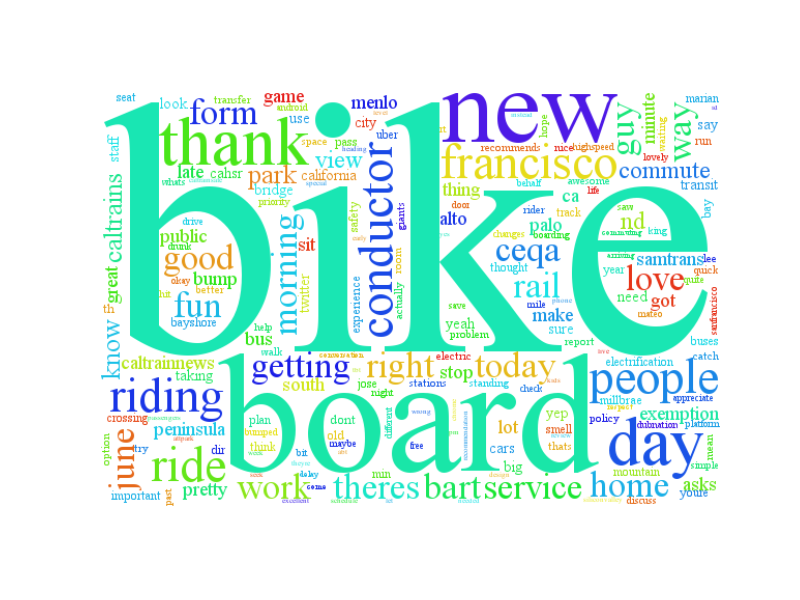

In [86]:
from IPython.display import Image
Image(filename='sentiment-positive.png')

### Negative

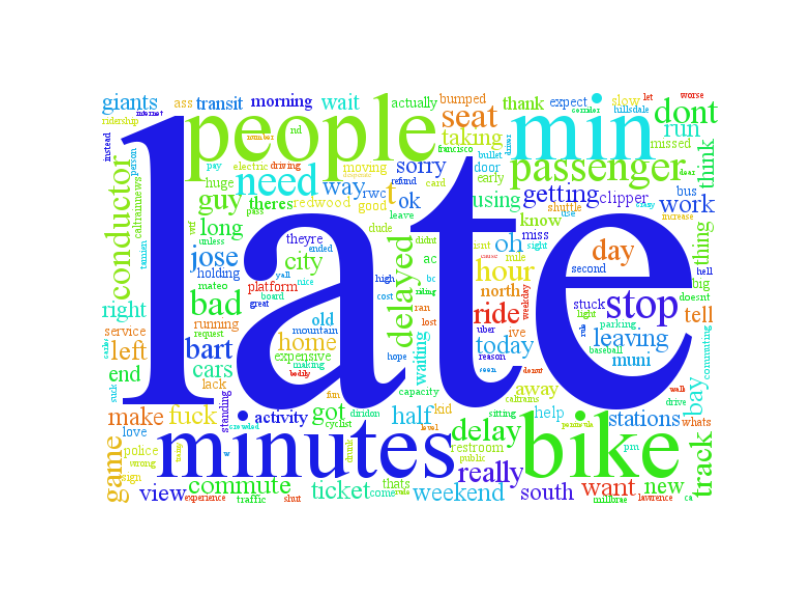

In [85]:
Image(filename='sentiment-negative.png')